In [2]:
%load_ext autoreload
%autoreload 2

In [8]:
import os, sys
import numpy as np 
# import pandas as pd 
import matplotlib.pyplot as plt
# import geopandas as gpd
import sklearn, sklearn.cross_decomposition
from sklearn.cross_decomposition import CCA

import scipy.cluster
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from tqdm import tqdm
sys.path.append('../src/')
sys.path.append('../content/')
import data_utils as du
import loadpaths
path_dict_pecl = loadpaths.loadpaths()
import analysis_utils as au


In [4]:

# Then collect from all patches the alpha and dyn data
patches = 200
hypotheses = []
features = []
sentinel = []
for p in range(patches):
    # (data_sent, data_alpha, data_dyn, data_worldclim, data_dsm) = du.load_all_modalities_from_name(name=f'pecl-fig-{p}', path_folder='../content/sample_data', verbose=1)
    (data_sent, data_alpha, data_dyn, data_worldclim, data_dsm) = du.load_all_modalities_from_name(name=f'pecl176-{p}', path_folder='/Users/tplas/data/2025-10 neureo/pecl-100-subsample-30km', verbose=0)
    
    if data_sent is None:
        continue
    # Land coverage and DSM serve as hypotheses
    assert len(data_dyn.data.shape) == 3 and len(data_dsm.data.shape) == 3 and data_dyn.data.shape[1:] == data_dsm.data.shape[1:]
    hypotheses.append(np.concatenate([data_dyn.data, data_dsm.data], axis=0))
    # This can definitely be cleaner but I use nan for undefined values
    f_dat = data_alpha.data
    f_dat[~np.isfinite(f_dat)] = np.nan
    features.append(f_dat)    
    sentinel.append(data_sent.data)

# # Z-score across patches for each feature and each hypothesis
# feat_m = np.stack([np.nanmean(f) for f in np.stack(features, axis=-1)])
# feat_std = np.stack([np.nanstd(f) for f in np.stack(features, axis=-1)])
# features = [(f - feat_m[:,None,None])/feat_std[:,None,None] for f in features]
# hyp_m = np.stack([np.nanmean(h) for h in np.stack(hypotheses, axis=-1)])
# hyp_std = np.stack([np.nanstd(h) for h in np.stack(hypotheses, axis=-1)])
# hypotheses = [(h - hyp_m[:,None,None])/hyp_std[:,None,None] for h in hypotheses]


## Spatial autocorr:

In [ ]:

from libpysal.weights import lat2W
from esda.moran import Moran
from splot.esda import moran_scatterplot


In [17]:
n_features = len(features[0])
n_patches = len(features)
assert n_features == 64 and n_patches == 100

vals_moran = np.zeros((n_features, n_patches))
for i_patch in tqdm(range(n_patches)):
    for i, f in enumerate(features[i_patch]):
        data = f
        col, row = data.shape
        WeightMatrix = lat2W(row, col)
        WeightMatrix = lat2W(data.shape[0], data.shape[1])
        moran = Moran(data, WeightMatrix).I
        # if moran == np.nan:
        #     break
        vals_moran[i, i_patch] = moran


100%|██████████| 100/100 [29:43<00:00, 17.84s/it]


array([49, 43, 28, 23, 26, 51, 38, 20, 31, 62, 13,  2, 36, 47, 30, 17, 60,
       19,  9, 12,  0, 55, 33, 14, 58,  4,  5,  6, 54, 16,  8, 29, 59, 61,
       48,  3, 63, 53, 11,  1, 39, 21, 46, 15, 44,  7, 52, 57, 41, 24, 37,
       10, 50, 22, 56, 35, 25, 32, 18, 34, 27, 45, 42, 40])

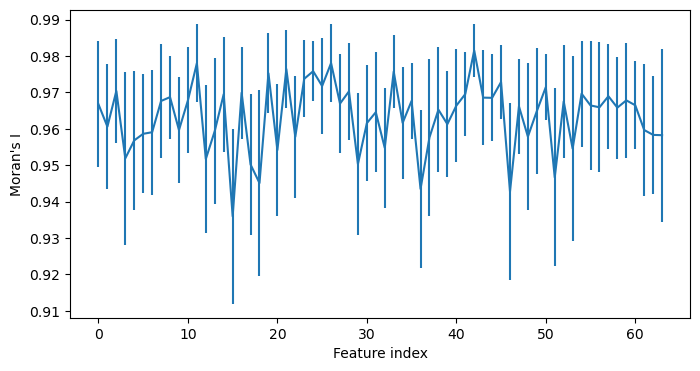

In [32]:
vals_moran_nonnan = vals_moran[:, np.sum(np.isnan(vals_moran), axis=0) == 0]
mean_moran = np.mean(vals_moran_nonnan, axis=1)
std_moran = np.std(vals_moran_nonnan, axis=1)
inds_sort = np.array(dendro['leaves'])
plt.figure(figsize=(8,4))
plt.errorbar(np.arange(len(mean_moran)), mean_moran[inds_sort], yerr=std_moran[inds_sort])
plt.xlabel('Feature index')
plt.ylabel("Moran's I")

np.argsort(mean_moran)

In [22]:
np.sum(np.isnan(vals_moran), axis=0)

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 64,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 64,  0,
        0,  0,  0,  0,  0, 64,  0,  0,  0,  0, 64,  0,  0,  0,  0,  0, 64,
        0,  0,  0, 64,  0, 64,  0, 64,  0, 64,  0,  0, 64,  0,  0,  0,  0,
        0,  0, 64, 64,  0,  0,  0, 64,  0, 64,  0,  0,  0,  0, 64,  0,  0,
       64,  0,  0,  0, 64, 64,  0,  0, 64,  0,  0, 64,  0,  0, 64])

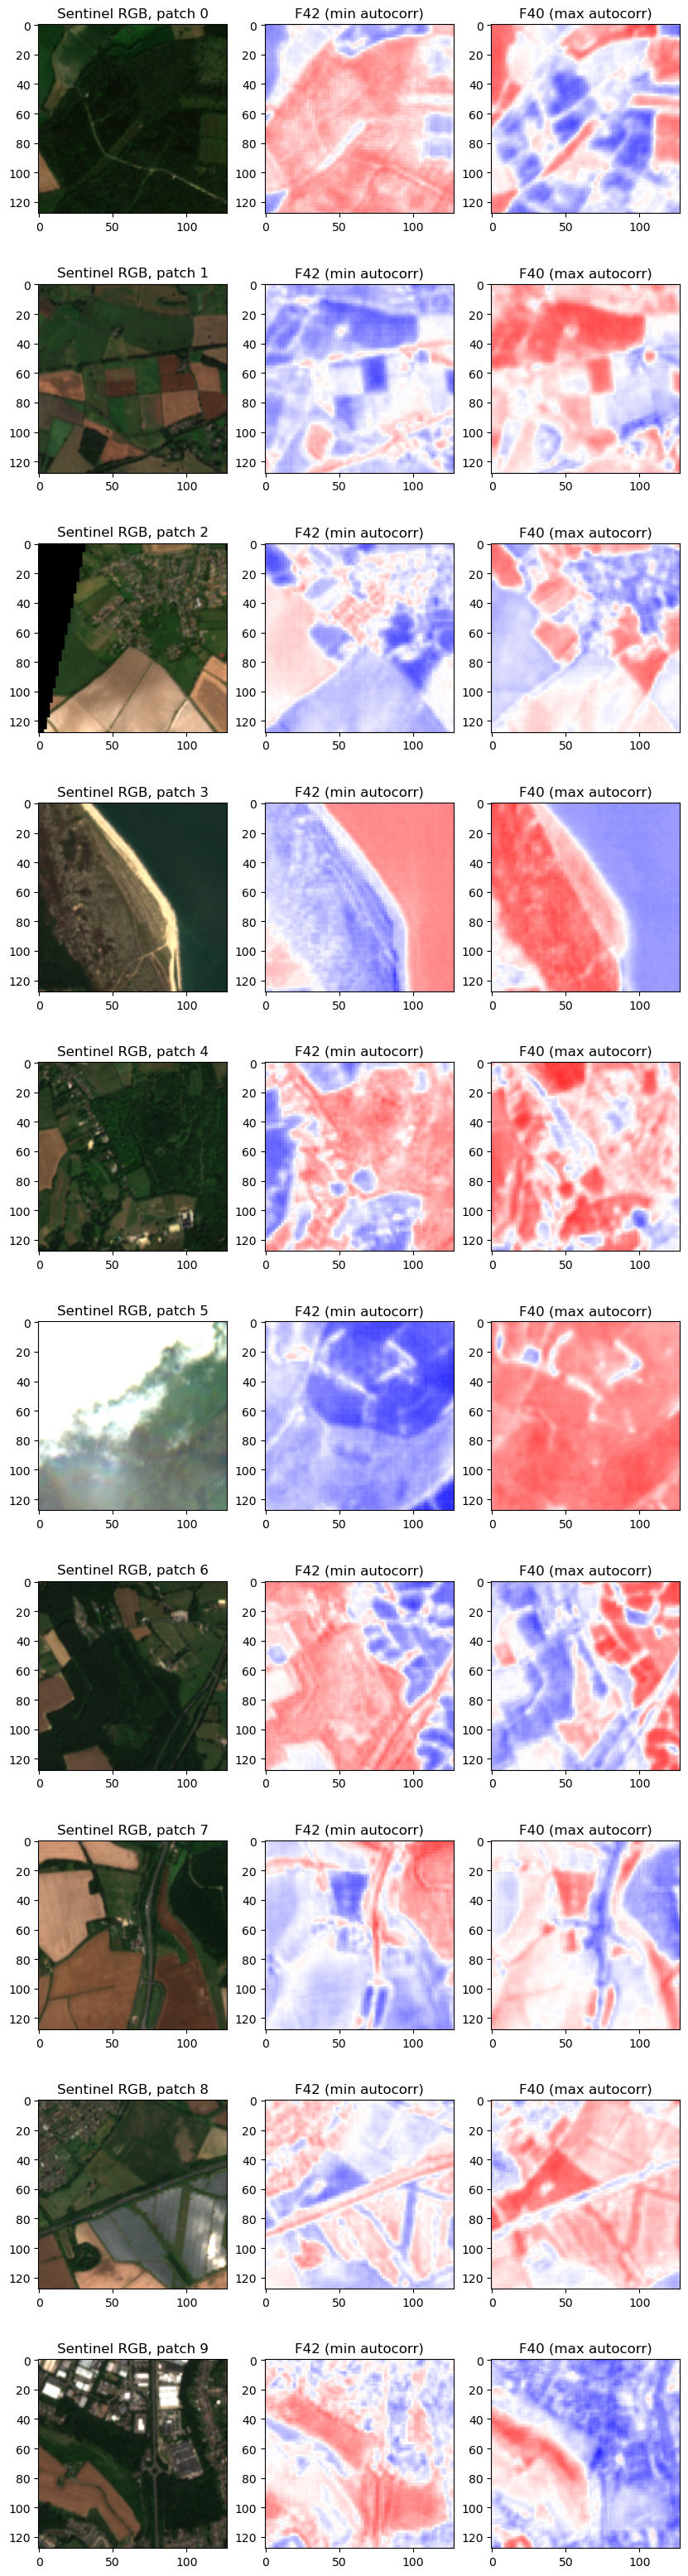

In [29]:
fig, ax = plt.subplots(10,3, figsize=(10,40))
ind_min, ind_max = 42, 40
lim_minf = np.nanmax(np.abs(np.stack(features, axis=-1)[ind_min, ...]))
lim_maxf = np.nanmax(np.abs(np.stack(features, axis=-1)[ind_max, ...]))
for i_patch in range(10):

    # ind_min, val_min = np.argsort(vals_moran)[3], np.min(vals_moran)
    # ind_max, val_max = np.argmax(vals_moran), np.max(vals_moran)
    # ind_min, ind_max = 62, 48
    # val_min, val_max = vals_moran[ind_min], vals_moran[ind_max]

    ax[i_patch, 0].imshow(np.clip(np.swapaxes(np.swapaxes(sentinel[i_patch][:3], 0, 2), 0, 1), 0, 3000) / 3000)
    ax[i_patch, 0].set_title(f'Sentinel RGB, patch {i_patch}')

    lim = np.abs(features[i_patch][ind_min]).max()
    ax[i_patch, 1].imshow(features[i_patch][ind_min], vmin=-lim_minf, vmax=lim_minf, cmap='bwr')
    # ax[i_patch, 1].set_title(f'F{ind_min} (min autocorr):\n Moran I = {val_min:.2f}')
    ax[i_patch, 1].set_title(f'F{ind_min} (min autocorr)')

    lim = np.abs(features[i_patch][ind_max]).max()
    ax[i_patch, 2].imshow(features[i_patch][ind_max], vmin=-lim_maxf, vmax=lim_maxf, cmap='bwr')
    # ax[i_patch, 2].set_title(f'F{ind_max} (max autocorr):\n Moran I = {val_max:.2f}')
    ax[i_patch, 2].set_title(f'F{ind_max} (max autocorr)')


In [113]:
features[0]

array([[[            nan, -1.30165321e-01, -1.24567474e-01, ...,
         -1.92910419e-01, -1.99861592e-01, -1.99861592e-01],
        [            nan, -1.35886198e-01, -1.24567474e-01, ...,
         -1.99861592e-01, -2.06935794e-01, -2.06935794e-01],
        [            nan, -1.35886198e-01, -1.30165321e-01, ...,
         -2.06935794e-01, -2.06935794e-01, -2.14133026e-01],
        ...,
        [-1.92910419e-01, -2.06935794e-01, -1.86082276e-01, ...,
         -1.86082276e-01, -1.92910419e-01, -1.92910419e-01],
        [-1.99861592e-01, -2.06935794e-01, -1.86082276e-01, ...,
         -1.79377163e-01, -1.86082276e-01, -1.86082276e-01],
        [-2.06935794e-01, -2.06935794e-01, -1.79377163e-01, ...,
         -1.92910419e-01, -1.99861592e-01, -1.92910419e-01]],

       [[            nan, -1.41730104e-01, -1.30165321e-01, ...,
         -1.99861592e-01, -1.86082276e-01, -1.72795079e-01],
        [            nan, -1.41730104e-01, -1.30165321e-01, ...,
         -1.99861592e-01, -1.86082276e

## Corr & dim

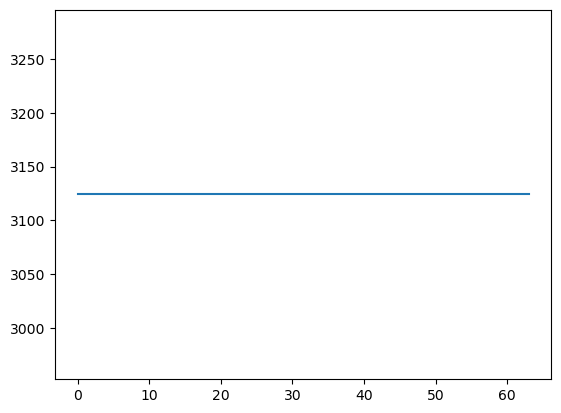

In [7]:
features_all = np.stack(features, axis=0)
features_all = au.ravel_features(features_all)

np.sum(np.isnan(features_all))
plt.plot(np.sum(np.isnan(features_all), axis=1))

## Set to 0 
features_all = features_all[:, np.isnan(features_all).sum(0) == 0]

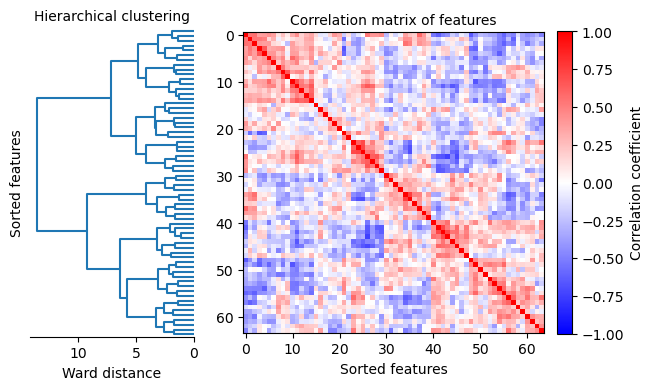

In [13]:
## Hierarchical clustering of features
corr_mat = np.corrcoef(features_all)
Z = linkage(corr_mat, 'ward')

fig, ax = plt.subplots(1, 2, figsize=(7, 4), gridspec_kw={'width_ratios': [1, 2], 'hspace': 0.0})

dendro = dendrogram(Z, orientation='left', leaf_rotation=0., 
                    leaf_font_size=8., ax=ax[0], color_threshold=0,
                    leaf_label_func=lambda x: str() if x % 10 == 0 else '')
ax[0].set_title('Hierarchical clustering', fontsize=10)
ax[0].set_xlabel('Ward distance')
ax[0].set_ylabel('Sorted features')
ax[0].invert_yaxis()
for sp in ['left', 'top', 'right']:
    ax[0].spines[sp].set_visible(False)


corr_mat_sorted = corr_mat[dendro['leaves'], :][:, dendro['leaves']]
ax[1].imshow(corr_mat_sorted, vmin=-1, vmax=1, cmap='bwr')
ax[1].set_xlabel('Sorted features')
ax[1].set_title('Correlation matrix of features', fontsize=10)
## cbar
cbar = plt.colorbar(mappable=ax[1].images[0], ax=ax[1], fraction=0.046, pad=0.04, label='Correlation coefficient')

In [11]:
np.array(dendro['leaves'])

array([63, 14, 50, 31, 36,  9, 12,  1,  7, 55, 21, 45, 20,  0, 57, 49, 37,
       51, 23, 32, 62, 27, 30, 25, 34, 56, 42, 53, 10, 38,  4,  6,  2, 18,
        5, 39, 28, 47, 16, 58, 61, 41, 40, 44, 15, 35, 43, 59, 17, 54, 22,
       26, 11, 13, 24, 48, 29, 52,  8, 46,  3, 33, 19, 60])

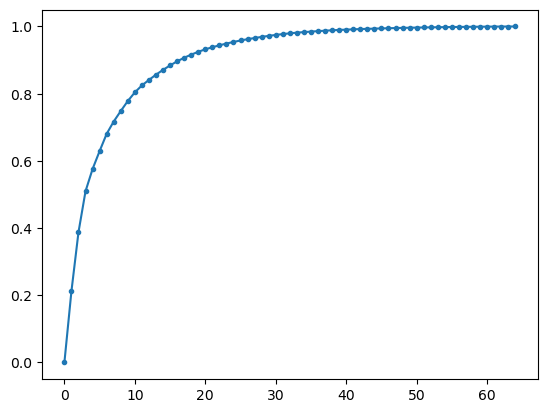

In [26]:
pca = sklearn.decomposition.PCA(n_components=64)
pca.fit(features_all.T)
plt.plot(np.concatenate([[0], np.cumsum(pca.explained_variance_ratio_)]), '.-')

In [25]:
sum_squares = np.sum(np.power(pca.explained_variance_, 2))
square_sum = np.sum(pca.explained_variance_) ** 2
float(square_sum / sum_squares)

9.393605263596568

In [34]:
ax_left

<Axes: title={'center': 'Hierarchical clustering'}, xlabel='Ward distance', ylabel='Sorted features'>

In [ ]:
plt.bar(np.arange(len(mean_moran)), mean_moran[inds_sort])

AttributeError: module 'matplotlib.pyplot' has no attribute 'hbar'

Text(0.5, 1.0, 'Spatial autocorrelation')

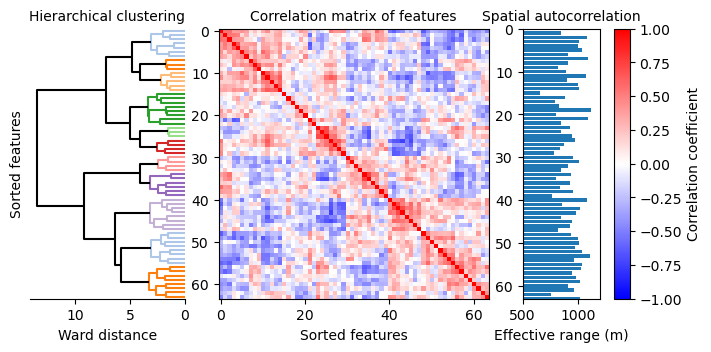

In [105]:
colors_clusters = {ii: col for ii, col in enumerate(['#4477AA', '#EE6677', '#228833', '#CCBB44', '#66CCEE', '#AA3377', '#BBBBBB'])}
# plt.rcParams['axes.prop_cycle'] = plt.cycler(color=colors_clusters.values())
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.tab20.colors)
# fig, ax = plt.subplots(1, 2, figsize=(7, 4), gridspec_kw={'width_ratios': [1, 2], 'hspace': 0.0})
fig = plt.figure(figsize=(8, 3))

gs_left = fig.add_gridspec(1, 4, width_ratios=[2, 4, 1, 0.2], wspace=0.1, 
                           left=0, right=0.75, bottom=0.05, top=0.95)
gs_right = fig.add_gridspec(2, 1, left=0.85, right=1, bottom=0.05, top=0.95, hspace=0.3)
ax_left = [fig.add_subplot(gs_left[:, ii]) for ii in range(4)]
# ax_right = [fig.add_subplot(gs_right[ii, :]) for ii in range(2)]
## Hierarchical clustering of features
corr_mat = np.corrcoef(features_all)
Z = linkage(corr_mat, 'ward')
dendro = dendrogram(Z, orientation='left', leaf_rotation=0., 
                    leaf_font_size=8., ax=ax_left[0], color_threshold=4,
                    above_threshold_color='k', #link_color_func=lambda k: colors_clusters[fcluster(Z, 7, criterion='maxclust')[k]] ,
                    leaf_label_func=lambda x: str() if x % 10 == 0 else '')
ax_left[0].set_title('Hierarchical clustering', fontsize=10)
ax_left[0].set_xlabel('Ward distance')
ax_left[0].set_ylabel('Sorted features')
ax_left[0].invert_yaxis()
for sp in ['left', 'top', 'right']:
    ax_left[0].spines[sp].set_visible(False)


corr_mat_sorted = corr_mat[dendro['leaves'], :][:, dendro['leaves']]
ax_left[1].imshow(corr_mat_sorted, vmin=-1, vmax=1, cmap='bwr')
ax_left[1].set_xlabel('Sorted features')
ax_left[1].set_title('Correlation matrix of features', fontsize=10)
## cbar
cbar = plt.colorbar(mappable=ax_left[1].images[0], ax=ax_left[1], #fraction=0.046, pad=0.04, 
                    cax=ax_left[3],
                    label='Correlation coefficient')


ax_left[2].barh(np.arange(len(mean_moran)), mat_effective_range_sorted.mean(axis=1))
ax_left[2].set_xlim(500, 1200)
ax_left[2].set_ylim(0, 63)
ax_left[2].invert_yaxis()
ax_left[2].set_xlabel("Effective range (m)")
ax_left[2].set_title("Spatial autocorrelation", fontsize=10)

(79, 64)


Text(0.5, 0, 'Sorted features')

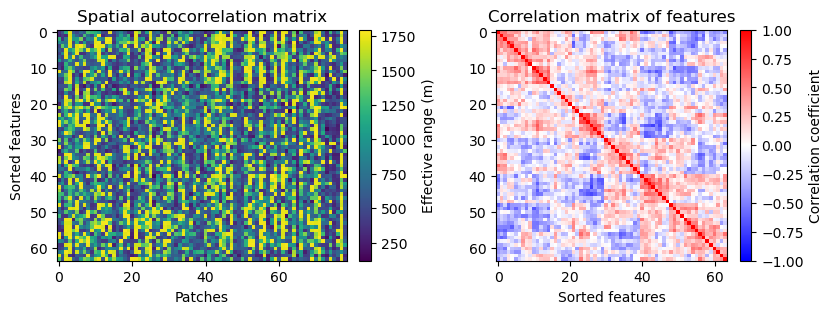

In [111]:
mat_effective_range = np.load('../outputs/spatial_autocorr_pecl100-30km.npy')
print(mat_effective_range.shape)
mat_effective_range_sorted = mat_effective_range[:, dendro['leaves']].T

fig, ax = plt.subplots(1, 2, figsize=(9, 3), gridspec_kw={'width_ratios': [1, 1], 'hspace': 0.5})

im0 = ax[0].imshow(mat_effective_range_sorted, cmap='viridis', aspect='auto')
ax[0].set_title('Spatial autocorrelation matrix')
cbar0 = plt.colorbar(im0, ax=ax[0], fraction=0.046, pad=0.04, label='Effective range (m)')
ax[0].set_xlabel('Patches')
ax[0].set_ylabel('Sorted features')

im1 = ax[1].imshow(corr_mat_sorted, vmin=-1, vmax=1, cmap='bwr')
ax[1].set_title('Correlation matrix of features')
cbar1 = plt.colorbar(im1, ax=ax[1], fraction=0.046, pad=0.04, label='Correlation coefficient')
ax[1].set_xlabel('Sorted features')

In [99]:
mat_effective_range_sorted.mean(axis=1).max()

np.float64(1150.1054872229956)

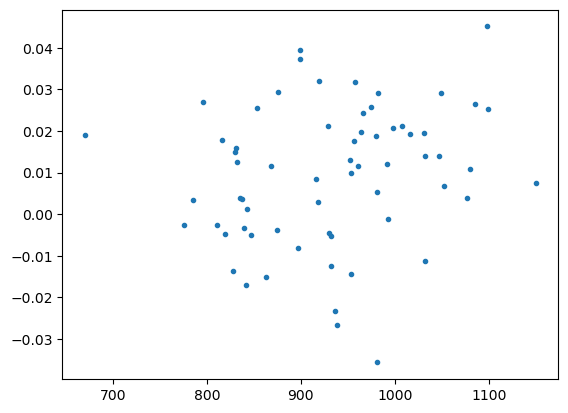

In [103]:
plt.plot(mat_effective_range_sorted.mean(axis=1), corr_mat_sorted.mean(axis=1), '.')